In [1]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
desired_res = (32, 32, 32)

In [3]:

foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
	knot: it for it, knot in enumerate(knots)
}

# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
# List of folders to search for data
# folders = [
#     '../4foils_L270_0.15_50_64x64x64_v1',
#     '../4foils_L270_0.05_50_64x64x64_v1',
#     '../4foils_L270_0.25_50_64x64x64_v1'
# ]
folders = [
	'../4foils_L270_0.05_1_64x64x64_v1',

]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')


print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Shape: 64, 64, 64
Loaded 132 samples.  11 per class


In [4]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch_dots = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_dots = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch_dots.shape, y_dots.shape)

test_dataset_dots = TensorDataset(X_torch_dots, y_dots)

torch.Size([132, 1, 32, 32, 32]) torch.Size([132, 12])


In [5]:
# train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader_dots = DataLoader(test_dataset_dots, batch_size=hyperparams['batch_size'])

In [7]:

# Load the saved model
model_path = "classifier3d_model.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


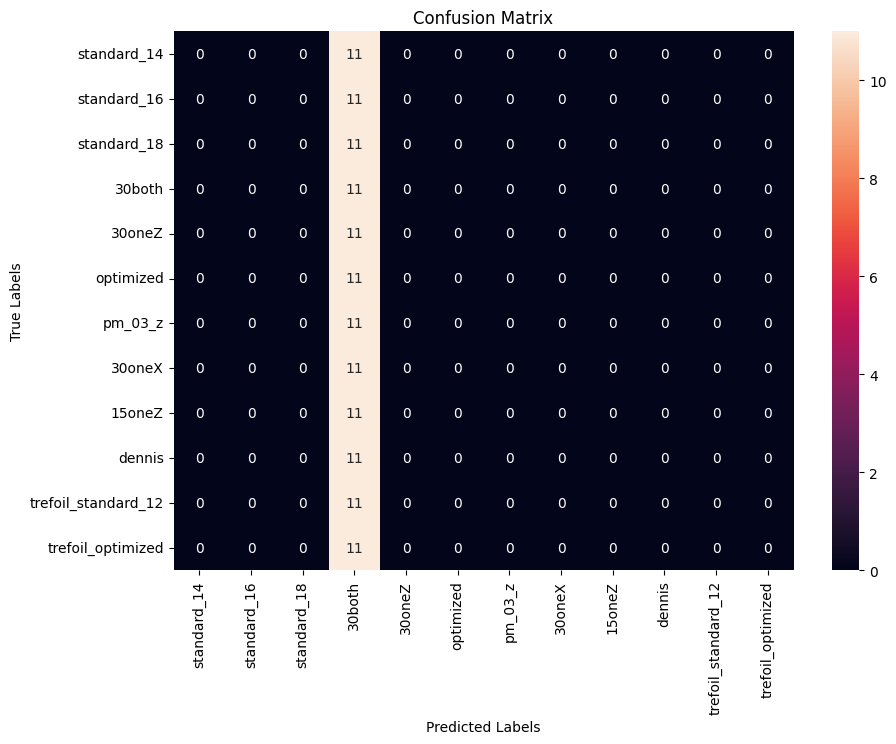

In [10]:
model_3D.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots:
        inputs = batch[0].to(device)
        outputs = model_3D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_dots, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# exit()